# Урок 5. Случайный лес


2. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.


In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=2, random_state=23)

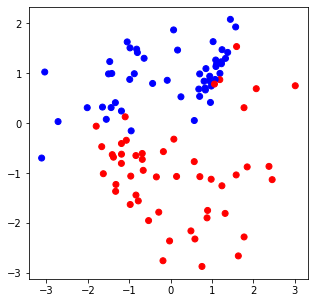

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(5,5))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [12]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Изменим функции

In [15]:
def get_bootstrap(data, labels, N):
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    tree_oob = {} # словарь "индекс дерева: список не используемых при обучении объектов"
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        idx = [] # индексы объектов, которые попадут в бутстреп выборку
                
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            idx.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]

        bootstrap.append((b_data, b_labels))
        tree_oob[i] = np.setdiff1d(np.array(range(n_samples)), 
                                   np.array(idx))
    return bootstrap, tree_oob

In [16]:
data = np.array([[0, 0], [1,1], [2, 2], [3,3], [4,4]])
labels = np.array([0,1,2,3,4])
b, x = get_bootstrap(data, labels, 3)
for _ in range(3):
    print(b[_][1])
x

[0. 0. 2. 1. 1.]
[1. 0. 4. 0. 4.]
[3. 0. 0. 0. 1.]


{0: array([3, 4]), 1: array([2, 3]), 2: array([2, 4])}

In [17]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, oob_index = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
           
    return forest, oob_index

In [18]:
def tree_vote(forest, data, labels, oob_score=False):
    
    forest_, oob_index = forest
       
    # добавим предсказания всех деревьев в список
    predictions = []
    accuracy_oob = []
    for num_tree, tree in enumerate(forest_):
        predictions.append(predict(data, tree))
        if oob_score:
            data_oob = data[oob_index[num_tree]]
            labels_oob = labels[oob_index[num_tree]]
            preds = predict(data_oob, tree)
            accuracy_oob.append(accuracy_metric(labels_oob, preds))      
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    if oob_score:
        print('Accuracy (OOB) = {0:.2f}%'.format(np.mean(accuracy_oob)))
        
    return voted_predictions

In [19]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    try:
        result = correct / float(len(actual)) * 100.0
    except:
        result = 100.0
    return result

In [20]:
n_trees = 3
my_forest = random_forest(classification_data, classification_labels, n_trees)
answers = tree_vote(my_forest, classification_data, classification_labels, oob_score=True)
accuracy = accuracy_metric(classification_labels, answers)
print('Accuracy (full_data) = {0:.2f}%'.format(accuracy))

Accuracy (OOB) = 86.66%
Accuracy (full_data) = 97.00%
